In [36]:
pip install brokenaxes

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import itertools
import math
from numpy.linalg import svd, norm

In [ ]:
def myPCA(X, n_components):

    N, M = X.shape

    mu = np.mean(X, axis=0)

    X_centered = X - mu

    V, L, U_t = np.linalg.svd(X_centered, full_matrices=False)

    index_sort = np.argsort(L)[::-1]
    L = np.diag(L[index_sort])
    V = V[:, index_sort]
    U_t = U_t[index_sort, :]

    U_t_pca = U_t[:n_components, :]
    F_pca = V[:, :n_components]@L[:n_components, :n_components]

    return U_t_pca.T, F_pca, mu


def naive_PCA(X, n_components, nb_it, early_stop=False):
    N, M = X.shape

    W = ~np.isnan(X)
    W_float = W.astype(float)

    mu = np.nanmean(X, axis=0)
    mu = np.nan_to_num(mu, nan=0.0)
    mu = mu.reshape(1, -1)

    X_centered = X - mu
    X_centered[~W] = 0

    X_init = X.copy()
    for m in range(M):
        mask = np.isnan(X_init[:, m])
        if np.any(~mask):
            X_init[mask, m] = np.nanmean(X[:, m])
        else:
            X_init[:, m] = 0
    
    X_init_centered = X_init - mu
    U_svd, s_svd, Vt_svd = np.linalg.svd(X_init_centered, full_matrices=False)
    
    F = U_svd[:, :n_components] @ np.diag(np.sqrt(s_svd[:n_components]))
    U = Vt_svd[:n_components, :].T @ np.diag(np.sqrt(s_svd[:n_components]))

    J = np.zeros(nb_it)
    
    total_observed = np.sum(W_float)

    for it in range(nb_it):
        F_old = F.copy()
        U_old = U.copy()
        
        for n in range(N):
            if np.sum(W[n, :]) > 0:  
                
                U_weighted = U * W_float[n, :, np.newaxis]  
                
                numerator = X_centered[n, :] @ U_weighted  
                
                denominator = U_weighted.T @ U  
                
                try:
                    F[n, :] = np.linalg.solve(denominator + 1e-6 * np.eye(n_components), numerator)
                except:
                    F[n, :] = F_old[n, :]

        for m in range(M):
            if np.sum(W[:, m]) > 0:  
                
                F_weighted = F * W_float[:, m, np.newaxis]  
                
                numerator = F_weighted.T @ X_centered[:, m]  
                
                denominator = F_weighted.T @ F  
                
                try:
                    U[m, :] = np.linalg.solve(denominator + 1e-6 * np.eye(n_components), numerator)
                except:
                    U[m, :] = U_old[m, :]

        X_reconstructed = F @ U.T + mu
        residuals = np.where(W, X - X_reconstructed, 0)
        J[it] = np.sum(residuals ** 2) / total_observed 
        
        if early_stop and it > 0 and np.abs(J[it] - J[it-1]) / J[it-1] < 1e-6:
            print(f"Converged at iteration {it}")
            J = J[:it+1]
            break
        
        if it % 10 == 0:
            print(f"Iteration {it}: J = {J[it]:.6f}, max|F| = {np.max(np.abs(F)):.3f}, max|U| = {np.max(np.abs(U)):.3f}")

    UTU = U.T @ U
    eigenvalues, V = np.linalg.eigh(UTU)

    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    V = V[:, idx]

    eigenvalues = np.maximum(eigenvalues, 1e-10)
    
    P = V @ np.diag(eigenvalues ** -0.5)

    U_pca = U @ P
    F_pca = F @ np.linalg.inv(P.T)

    return F_pca, U_pca, mu.flatten(), J


def IPCA(data, n_components, nb_it, early_stop=False):
    
    N, M = data.shape  
    
    W = (~np.isnan(data)).astype(float)  # 1 for observed, 0 for missing
    
    mu = np.nanmean(data, axis=0)
    mu = np.nan_to_num(mu, nan=0.0)
    
    X = data.copy()
    X_imputed = np.zeros((N, M))
    # Missing values get mean, observed values stay
    X_imputed[W == 0] = np.tile(mu, (N, 1))[W == 0]  
    X_imputed[W == 1] = X[W == 1]  

    U = np.random.randn(M, n_components)
    FU = np.zeros((N, M))
    
    J = np.zeros(nb_it)
    
    total_observed = np.sum(W)
    
    for indIt in range(nb_it):  
        mu_imputed = np.mean(X_imputed, axis=0)
        
        X_imputedCentered = X_imputed - mu_imputed
        
        U_svd, s_svd, Vt_svd = np.linalg.svd(X_imputedCentered, full_matrices=False)
        
        F = U_svd[:, :n_components] @ np.diag(s_svd[:n_components])
        U = Vt_svd[:n_components, :].T
        
        FU = F @ U.T
        
        residuals_squared = np.where(W == 1, (data - (FU + mu_imputed)) ** 2, 0)
        J[indIt] = np.sum(residuals_squared) / total_observed
        
        if early_stop and indIt > 0 and np.abs(J[indIt] - J[indIt-1]) / J[indIt-1] < 1e-6:
            print(f"Converged at iteration {indIt}")
            J = J[:indIt+1]
            break
        
        # Update imputation
        X_imputed = np.zeros((N, M))
        X_imputed[W == 0] = (FU + mu_imputed)[W == 0]  # Impute missing values
        X_imputed[W == 1] = X[W == 1]  # Keep observed values
        
        if indIt % 10 == 0:
            print(f"Iteration {indIt}: J = {J[indIt]:.6f}")
    
    mu = mu_imputed
    
    UTU = U.T @ U
    eigenvalues, V = np.linalg.eigh(UTU)
    
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    V = V[:, idx]
    
    eigenvalues = np.maximum(eigenvalues, 1e-10)
    
    P = V @ np.diag(eigenvalues ** -0.5)
    
    U_ortho = U @ P
    F_ortho = F @ np.linalg.inv(P.T)
    
    return F_ortho, U_ortho, mu, J


def PPCA(Data, K, nbIt, early_stop=False):
    
    N, M = Data.shape  
    
    indexMissingSampleTmp = np.isnan(Data)
    indexMissingSample = []
    indexObservedSample = []
    
    for n in range(N):
        indexMissingSample.append(np.where(indexMissingSampleTmp[n, :])[0])
        indexObservedSample.append(np.where(~indexMissingSampleTmp[n, :])[0])
    
    mu_0 = np.nanmean(Data, axis=0)
    mu_0 = np.nan_to_num(mu_0, nan=0.0)
    
    Gamma_0 = np.random.randn(M, K) * 0.1
    
    mu = mu_0.copy()
    Gamma = Gamma_0.copy()
    sigma2 = np.random.rand() * 0.1 + 0.1
    
    E_xi = np.zeros((M, N))
    E_zi = np.zeros((K, N))
    E_zizi = np.zeros((K, K, N))
    E_xizi = np.zeros((M, K, N))
    E_xixi = np.zeros((M, M, N))
    
    J_history = []
    
    for indIt in range(nbIt):
        # E-step
        for n in range(N):
            nbO = len(indexObservedSample[n])  
            nbM = len(indexMissingSample[n])   
            
            if nbO == 0:  
                continue
            
            xo = Data[n, indexObservedSample[n]]       
            mu_o = mu[indexObservedSample[n]]          

            Gamma_o = Gamma[indexObservedSample[n], :]  
            
            Sigma_xo_xo = Gamma_o @ Gamma_o.T + sigma2 * np.eye(nbO)
            
            Sigma_xo_xo_inv = np.linalg.inv(Sigma_xo_xo)
            
            mu_z_G_xo = Gamma_o.T @ Sigma_xo_xo_inv @ (xo - mu_o)
            
            Sigma_z_z_G_xo = np.eye(K) - Gamma_o.T @ Sigma_xo_xo_inv @ Gamma_o
            
            E_zi[:, n] = mu_z_G_xo
            
            E_zizi[:, :, n] = Sigma_z_z_G_xo + np.outer(mu_z_G_xo, mu_z_G_xo)
            
            E_xi[indexObservedSample[n], n] = xo
            
            if nbM > 0:
                mu_m = mu[indexMissingSample[n]]
                Gamma_m = Gamma[indexMissingSample[n], :]
                
                Sigma_xm_xo = Gamma_m @ Gamma_o.T
                mu_xm_G_xo = mu_m + Sigma_xm_xo @ Sigma_xo_xo_inv @ (xo - mu_o)
                
                Sigma_xm_xm_G_xo = Gamma_m @ Gamma_m.T + sigma2 * np.eye(nbM) - Sigma_xm_xo @ Sigma_xo_xo_inv @ Sigma_xm_xo.T
                
                E_xi[indexMissingSample[n], n] = mu_xm_G_xo
                
                Sigma_xm_z_G_xo = Gamma_m @ (np.eye(K) - Gamma_o.T @ Sigma_xo_xo_inv @ Gamma_o)
                E_xizi[indexMissingSample[n], :, n] = Sigma_xm_z_G_xo + np.outer(mu_xm_G_xo, mu_z_G_xo)
                
                E_xixi[np.ix_(indexMissingSample[n], indexMissingSample[n], [n])][:, :, 0] = \
                    Sigma_xm_xm_G_xo + np.outer(mu_xm_G_xo, mu_xm_G_xo)
                E_xixi[np.ix_(indexMissingSample[n], indexObservedSample[n], [n])][:, :, 0] = \
                    np.outer(mu_xm_G_xo, xo)
                E_xixi[np.ix_(indexObservedSample[n], indexMissingSample[n], [n])][:, :, 0] = \
                    np.outer(xo, mu_xm_G_xo)
            
            E_xizi[indexObservedSample[n], :, n] = np.outer(xo, mu_z_G_xo)
            
            E_xixi[np.ix_(indexObservedSample[n], indexObservedSample[n], [n])][:, :, 0] = \
                np.outer(xo, xo)
        
        # M-step
        mu = np.mean(E_xi, axis=1)
        
        sum_term = 0
        for n in range(N):
            E_xi_n = E_xi[:, n]
            sum_term += np.trace(E_xixi[:, :, n]) - 2 * mu.T @ E_xi_n + np.dot(mu, mu)
            sum_term += - 2 * np.trace(E_xizi[:, :, n] @ Gamma.T)
            sum_term += 2 * mu.T @ Gamma @ E_zi[:, n]
            sum_term += np.trace(E_zizi[:, :, n] @ Gamma.T @ Gamma)
        
        sigma2 = sum_term / (N * M)
        sigma2 = max(sigma2, 1e-6) 
        
        sum_xizi = np.sum(E_xizi, axis=2)
        sum_zizi = np.sum(E_zizi, axis=2)
        
        mu_sum_zi = mu[:, np.newaxis] @ np.sum(E_zi, axis=1, keepdims=True).T
        
        Gamma = (sum_xizi - mu_sum_zi) @ np.linalg.inv(sum_zizi)
        
        # Calculate reconstruction error
        recon_error = 0
        total_observed = 0
        for n in range(N):
            if len(indexObservedSample[n]) > 0:
                xo = Data[n, indexObservedSample[n]]
                mu_o = mu[indexObservedSample[n]]
                Gamma_o = Gamma[indexObservedSample[n], :]
                recon = mu_o + Gamma_o @ E_zi[:, n]
                recon_error += np.sum((xo - recon) ** 2)
                total_observed += len(indexObservedSample[n])
        
        J = recon_error / total_observed if total_observed > 0 else 0
        J_history.append(J)
        
        if early_stop and indIt > 0 and np.abs(J_history[indIt] - J_history[indIt-1]) / J_history[indIt-1] < 1e-6:
            print(f"Converged at iteration {indIt}")
            J_history = J_history[:indIt+1]
            break
        
        if (indIt + 1) % 10 == 0:
            print(f"Iteration {indIt + 1}: J = {J:.6f}, sigma2 = {sigma2:.6f}")
    
    GammaT_Gamma = Gamma.T @ Gamma
    eigenvalues, V = np.linalg.eigh(GammaT_Gamma)
    
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    V = V[:, idx]
    
    eigenvalues = np.maximum(eigenvalues, 1e-10)
    
    P = V @ np.diag(eigenvalues ** -0.5)
    
    U_final = Gamma @ P
    F_final = E_zi.T @ np.linalg.inv(P.T)
    
    return F_final, U_final, mu, sigma2, J_history

In [4]:
def plot_correlation_circle(correlation_circle, name_variables, nb_axes, fig_number,
                            additional_corr_circle=None, additional_variable_names=None):
    """
    Plot correlation circles (like MATLAB's plot_CorrelationCircle).

    Parameters
    ----------
    correlation_circle : np.ndarray (P x P)
        Correlation coefficients between variables and principal components.
    name_variables : list of str
        Names of the original variables.
    nb_axes : int
        Number of principal components to display.
    fig_number : int
        Figure number (like MATLAB figure number).
    additional_corr_circle : np.ndarray, optional (Q x P)
        Correlation coefficients for additional variables.
    additional_variable_names : list of str, optional
        Names of additional variables.
    """

    nb_variables = correlation_circle.shape[1]
    comb = list(itertools.combinations(range(nb_axes), 2))
    nb_plots = len(comb)
    nb_cols = math.ceil(math.sqrt(nb_plots))
    nb_rows = math.ceil(nb_plots / nb_cols)

    plt.figure(fig_number, figsize=(4 * nb_cols, 4 * nb_rows))
    plt.clf()
    plt.suptitle("Correlation Circles", fontsize=14)

    for idx, (i1, i2) in enumerate(comb, start=1):
        ax = plt.subplot(nb_rows, nb_cols, idx)

        # Plot arrows for main correlation circle
        for j in range(correlation_circle.shape[0]):
            x = correlation_circle[j, i1]
            y = correlation_circle[j, i2]
            ax.arrow(0, 0, x, y,
                     head_width=0.03, head_length=0.05, fc='b', ec='b')
            ax.text(x * 1.1, y * 1.1, name_variables[j], fontsize=9, color='b')

        # Unit circle
        circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
        ax.add_artist(circle)

        # Axes
        ax.axhline(0, color='k', linewidth=0.8)
        ax.axvline(0, color='k', linewidth=0.8)

        # Plot additional correlation circle if given
        if additional_corr_circle is not None and additional_variable_names is not None:
            for j in range(additional_corr_circle.shape[0]):
                x = additional_corr_circle[j, i1]
                y = additional_corr_circle[j, i2]
                ax.arrow(0, 0, x, y,
                         head_width=0.03, head_length=0.05, fc='r', ec='r', linestyle='--')
                ax.text(x * 1.1, y * 1.1, additional_variable_names[j],
                        fontsize=9, color='r')

        # Formatting
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel(f'Component {i1 + 1}')
        ax.set_ylabel(f'Component {i2 + 1}')

    plt.tight_layout()
    plt.show()

def plot_projection_observation(C, index_selected_points, nb_axes, fig_number,
                                additional_C=None, index_additional_observations=None):
    """
    Plot the projection of observations on factorial planes (PCA component space).

    Parameters
    ----------
    C : np.ndarray (N x P)
        Coordinates of observations on the principal components.
    index_selected_points : array-like of int
        Indices of the selected observations among the original data.
    nb_axes : int
        Number of principal components to display.
    fig_number : int
        Figure number.
    additional_C : np.ndarray (M x P), optional
        Coordinates of additional observations on the principal components.
    index_additional_observations : array-like of int, optional
        Indices of the additional observations among the original data.
    """

    nb_variables = C.shape[1]

    # --- Validate optional args ---
    if additional_C is not None:
        if additional_C.shape[1] != nb_variables:
            raise ValueError("additional_C must have the same number of columns as C")
        if index_additional_observations is None:
            raise ValueError("You must provide 'index_additional_observations' with 'additional_C'")
        if len(index_additional_observations) != additional_C.shape[0]:
            raise ValueError("Length of index_additional_observations must match rows of additional_C")

    # --- Layout ---
    comb = list(itertools.combinations(range(nb_axes), 2))
    nb_plots = len(comb)
    nb_cols = math.ceil(math.sqrt(nb_plots))
    nb_rows = math.ceil(nb_plots / nb_cols)

    plt.figure(fig_number, figsize=(4 * nb_cols, 4 * nb_rows))
    plt.clf()
    plt.suptitle("Projection of Observations", fontsize=14)

    # --- Plot for each component pair ---
    for idx, (i1, i2) in enumerate(comb, start=1):
        ax = plt.subplot(nb_rows, nb_cols, idx)

        # Main observations
        ax.scatter(C[:, i1], C[:, i2],
                   c='C0', label='Selected observations', s=40, edgecolor='k', alpha=0.7)
        for j, (x, y) in enumerate(zip(C[:, i1], C[:, i2])):
            ax.text(x + 0.02, y - 0.02, str(index_selected_points[j]), fontsize=8, color='C0')

        # Additional observations
        if additional_C is not None and index_additional_observations is not None:
            ax.scatter(additional_C[:, i1], additional_C[:, i2],
                       marker='D', c='C1', label='Additional observations', s=50, edgecolor='k')
            for j, (x, y) in enumerate(zip(additional_C[:, i1], additional_C[:, i2])):
                ax.text(x + 0.02, y - 0.02, str(index_additional_observations[j]), fontsize=8, color='C1')

            val_min_x = min(np.min(C[:, i1]), np.min(additional_C[:, i1]))
            val_max_x = max(np.max(C[:, i1]), np.max(additional_C[:, i1]))
            val_min_y = min(np.min(C[:, i2]), np.min(additional_C[:, i2]))
            val_max_y = max(np.max(C[:, i2]), np.max(additional_C[:, i2]))
        else:
            val_min_x = np.min(C[:, i1])
            val_max_x = np.max(C[:, i1])
            val_min_y = np.min(C[:, i2])
            val_max_y = np.max(C[:, i2])

        # Axis formatting
        ax.grid(True)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(1.1 * np.array([val_min_x, val_max_x]))
        ax.set_ylim(1.1 * np.array([val_min_y, val_max_y]))
        ax.set_xlabel(f'Component {i1 + 1}')
        ax.set_ylabel(f'Component {i2 + 1}')
        if idx == 1:
            ax.legend()

    plt.tight_layout()
    plt.show()

def compute_angle(M, M_pca):

    Q_M, _ = np.linalg.qr(M)
    Q_M_pca, _ = np.linalg.qr(M_pca)

    M= Q_M.T @ Q_M_pca
    _, S, _ = np.linalg.svd(M)
    S = np.clip(S, -1, 1)
    angles = np.arccos(S)
    angle_U = np.max(angles)

    return angle_U

def reconstruct_error(X, X_bar):
    
    return norm(X - X_bar, ord="fro")**2/(X.shape[0]*X.shape[1])


## Exact PCA without missing data

In [5]:
X = np.random.normal(loc=0, scale=1, size=(1000, 12))
N, M = X.shape

K = 5
U, F, mu = myPCA(X, n_components=K)

#Orthonormalization of U and F
Q_U, Q_R = np.linalg.qr(U)
Q_F, Q_F = np.linalg.qr(F)

X = F @ U.T  # rk(X_bar) == K

print("PCA Evaluation")
start_time = time.time()
U_pca, F_pca, mu = myPCA(X, n_components=K)
end_time = time.time()

X_bar = F_pca @ U_pca.T

angle_U = compute_angle(U, U_pca)
angle_F = compute_angle(F, F_pca)
reco_error = reconstruct_error(X, X_bar)
delta_time = end_time - start_time

print(f"Angle of U and U_bar: {angle_U}")
print(f"Angle of F and F_bar: {angle_F}")
print(f"Reconstruction error: {reco_error}")
print(f"Time: {delta_time}")
print("----------------------------")

print("Naive PCA Evaluation")
start_time = time.time()
F_pca, U_pca, mu, J = naive_PCA(X, n_components=K, nb_it=50)
end_time = time.time()

X_bar = F_pca @ U_pca.T

angle_U = compute_angle(U, U_pca)
angle_F = compute_angle(F, F_pca)
reco_error = reconstruct_error(X, X_bar)
delta_time = end_time - start_time

print(f"Angle of U and U_bar: {angle_U}")
print(f"Angle of F and F_bar: {angle_F}")
print(f"Reconstruction error: {reco_error}")
print(f"Time: {delta_time}")
print("----------------------------")

print("Iterative PCA Evaluation")
start_time = time.time()
F_pca, U_pca, mu, J = IPCA(X, n_components=K, nb_it=50)
end_time = time.time()

X_bar = F_pca @ U_pca.T

angle_U = compute_angle(U, U_pca)
angle_F = compute_angle(F, F_pca)
reco_error = reconstruct_error(X, X_bar)
delta_time = end_time - start_time

print(f"Angle of U and U_bar: {angle_U}")
print(f"Angle of F and F_bar: {angle_F}")
print(f"Reconstruction error: {reco_error}")
print(f"Time: {delta_time}")
print("----------------------------")

print("Probabilistic PCA Evaluation")
start_time = time.time()
F_pca, U_pca, mu, sigma2, J = PPCA(X, K=K, nbIt=50)
end_time = time.time()

X_bar = F_pca @ U_pca.T

angle_U = compute_angle(U, U_pca)
angle_F = compute_angle(F, F_pca)
reco_error = reconstruct_error(X, X_bar)
delta_time = end_time - start_time

print(f"Angle of U and U_bar: {angle_U}")
print(f"Angle of F and F_bar: {angle_F}")
print(f"Reconstruction error: {reco_error}")
print(f"Time: {delta_time}")
print("----------------------------")

PCA Evaluation
Angle of U and U_bar: 0.0
Angle of F and F_bar: 4.2146848510894035e-08
Reconstruction error: 3.8786475665014454e-30
Time: 0.0007212162017822266
----------------------------
Naive PCA Evaluation
Iteration 0: J = 0.000000, max|F| = 0.879, max|U| = 4.059
Iteration 10: J = 0.000000, max|F| = 0.879, max|U| = 4.059
Iteration 20: J = 0.000000, max|F| = 0.879, max|U| = 4.059
Iteration 30: J = 0.000000, max|F| = 0.879, max|U| = 4.059
Iteration 40: J = 0.000000, max|F| = 0.879, max|U| = 4.059
Angle of U and U_bar: 2.1073424255447017e-08
Angle of F and F_bar: 4.712160915387242e-08
Reconstruction error: 4.166666824184585e-16
Time: 0.4749412536621094
----------------------------
Iterative PCA Evaluation
Iteration 0: J = 0.000000
Iteration 10: J = 0.000000
Iteration 20: J = 0.000000
Iteration 30: J = 0.000000
Iteration 40: J = 0.000000
Angle of U and U_bar: 2.1073424255447017e-08
Angle of F and F_bar: 2.9802322387695312e-08
Reconstruction error: 4.0117400937378706e-30
Time: 0.00872302

## Noisy data PCA

SNR=0 dB | Reconstruction Error True=0.1959 | Reconstruction Error Noisy=0.2735 | Angle U and U_hat:0.0860 rad | Angle F and F_hat:0.6346
SNR=10 dB | Reconstruction Error True=0.0193 | Reconstruction Error Noisy=0.0270 | Angle U and U_hat:0.0283 rad | Angle F and F_hat:0.2138
SNR=20 dB | Reconstruction Error True=0.0019 | Reconstruction Error Noisy=0.0027 | Angle U and U_hat:0.0072 rad | Angle F and F_hat:0.0679
SNR=30 dB | Reconstruction Error True=0.0002 | Reconstruction Error Noisy=0.0003 | Angle U and U_hat:0.0025 rad | Angle F and F_hat:0.0216


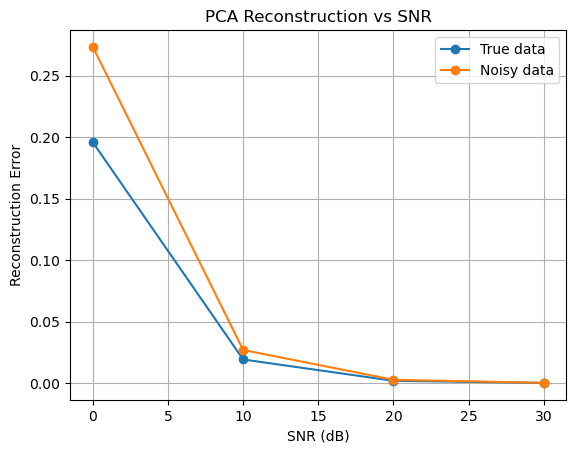

In [9]:
SNR_dB_list = [0, 10, 20, 30]
results_PCA = []
for SNR_dB in SNR_dB_list:
    Ps = norm(X, 'fro')**2 / (N*M)
    Pn = Ps / (10**(SNR_dB / 10))
    sigma = np.sqrt(Pn)
    B = sigma * np.random.randn(N, M)
    X_noisy = X + B

    U_pca, F_pca, mu = myPCA(X_noisy, n_components=K)  
    X_bar = F_pca @ U_pca.T
    
    reco_error_true = reconstruct_error(X, X_bar)
    reco_error_noisy = reconstruct_error(X_noisy, X_bar)
    angle_U = compute_angle(U, U_pca)
    angle_F = compute_angle(F, F_pca)
    results_PCA.append((SNR_dB, reco_error_true, reco_error_noisy , angle_U, angle_F))

for r in results_PCA:
    print(f"SNR={r[0]} dB | Reconstruction Error True={r[1]:.4f} | Reconstruction Error Noisy={r[2]:.4f} | Angle U and U_hat:{r[3]:.4f} rad | Angle F and F_hat:{r[4]:.4f}")

snr_vals, errors_true_PCA, errors_noisy_PCA, _, _ = zip(*results_PCA)
plt.plot(snr_vals, errors_true_PCA, marker='o', label="True data")
plt.plot(snr_vals, errors_noisy_PCA, marker='o', label="Noisy data")
plt.xlabel("SNR (dB)")
plt.ylabel("Reconstruction Error")
plt.title("PCA Reconstruction vs SNR")
plt.legend()
plt.grid(True)
plt.show()

Iteration 0: J = 0.269724, max|F| = 0.828, max|U| = 4.736
Iteration 10: J = 0.269724, max|F| = 0.828, max|U| = 4.736
Iteration 20: J = 0.269724, max|F| = 0.828, max|U| = 4.736
Iteration 30: J = 0.269724, max|F| = 0.828, max|U| = 4.736
Iteration 40: J = 0.269724, max|F| = 0.828, max|U| = 4.736
Iteration 0: J = 0.026435, max|F| = 0.905, max|U| = 4.145
Iteration 10: J = 0.026435, max|F| = 0.905, max|U| = 4.145
Iteration 20: J = 0.026435, max|F| = 0.905, max|U| = 4.145
Iteration 30: J = 0.026435, max|F| = 0.905, max|U| = 4.145
Iteration 40: J = 0.026435, max|F| = 0.905, max|U| = 4.145
Iteration 0: J = 0.002791, max|F| = 0.881, max|U| = 4.125
Iteration 10: J = 0.002791, max|F| = 0.881, max|U| = 4.125
Iteration 20: J = 0.002791, max|F| = 0.881, max|U| = 4.125
Iteration 30: J = 0.002791, max|F| = 0.881, max|U| = 4.125
Iteration 40: J = 0.002791, max|F| = 0.881, max|U| = 4.125
Iteration 0: J = 0.000271, max|F| = 0.864, max|U| = 4.036
Iteration 10: J = 0.000271, max|F| = 0.864, max|U| = 4.036
I

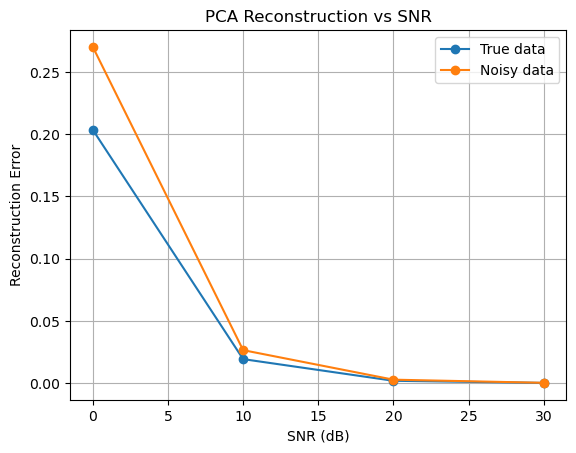

In [15]:
results_NPCA = []
for SNR_dB in SNR_dB_list:
    Ps = norm(X, 'fro')**2 / (N*M)
    Pn = Ps / (10**(SNR_dB / 10))
    sigma = np.sqrt(Pn)
    B = sigma * np.random.randn(N, M)
    X_noisy = X + B

    F_pca, U_pca, mu, J = naive_PCA(X_noisy, n_components=K, nb_it=50)
    X_bar = F_pca @ U_pca.T
    
    reco_error_true = reconstruct_error(X, X_bar)
    reco_error_noisy = reconstruct_error(X_noisy, X_bar)
    angle_U = compute_angle(U, U_pca)
    angle_F = compute_angle(F, F_pca)
    results_NPCA.append((SNR_dB, reco_error_true, reco_error_noisy, angle_U, angle_F, J))

for r in results_NPCA:
    print(f"SNR={r[0]} dB | Reconstruction Error True={r[1]:.4f} | Reconstruction Error Noisy={r[2]:.4f} | Angle U and U_hat:{r[3]:.4f} rad | Angle F and F_hat:{r[4]:.4f}")

snr_vals, errors_true_NPCA, errors_noisy_NPCA, _, _, J_NPCA = zip(*results_NPCA)
plt.plot(snr_vals, errors_true_NPCA, marker='o', label="True data")
plt.plot(snr_vals, errors_noisy_NPCA, marker='o', label="Noisy data")
plt.xlabel("SNR (dB)")
plt.ylabel("Reconstruction Error")
plt.title("PCA Reconstruction vs SNR")
plt.legend()
plt.grid(True)
plt.show()

Iteration 0: J = 0.267448
Iteration 10: J = 0.267448
Iteration 20: J = 0.267448
Iteration 30: J = 0.267448
Iteration 40: J = 0.267448
Iteration 0: J = 0.027074
Iteration 10: J = 0.027074
Iteration 20: J = 0.027074
Iteration 30: J = 0.027074
Iteration 40: J = 0.027074
Iteration 0: J = 0.002772
Iteration 10: J = 0.002772
Iteration 20: J = 0.002772
Iteration 30: J = 0.002772
Iteration 40: J = 0.002772
Iteration 0: J = 0.000262
Iteration 10: J = 0.000262
Iteration 20: J = 0.000262
Iteration 30: J = 0.000262
Iteration 40: J = 0.000262
SNR=0 dB | Reconstruction Error True=0.1967 | Reconstruction Error Noisy=0.2678 | Angle U and U_hat:0.0973 rad | Angle F and F_hat:0.5936
SNR=10 dB | Reconstruction Error True=0.0191 | Reconstruction Error Noisy=0.0272 | Angle U and U_hat:0.0355 rad | Angle F and F_hat:0.2149
SNR=20 dB | Reconstruction Error True=0.0020 | Reconstruction Error Noisy=0.0028 | Angle U and U_hat:0.0089 rad | Angle F and F_hat:0.0661
SNR=30 dB | Reconstruction Error True=0.0002 | R

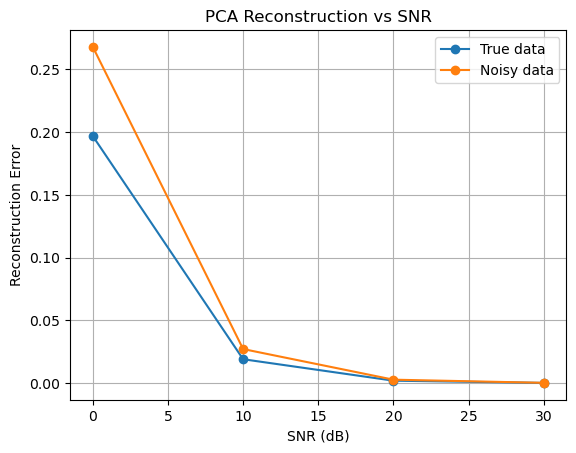

In [16]:
results_IPCA = []
for SNR_dB in SNR_dB_list:
    Ps = norm(X, 'fro')**2 / (N*M)
    Pn = Ps / (10**(SNR_dB / 10))
    sigma = np.sqrt(Pn)
    B = sigma * np.random.randn(N, M)
    X_noisy = X + B

    F_pca, U_pca, mu, J = IPCA(X_noisy, n_components=K, nb_it=50)
    X_bar = F_pca @ U_pca.T
    
    reco_error_true = reconstruct_error(X, X_bar)
    reco_error_noisy = reconstruct_error(X_noisy, X_bar)
    angle_U = compute_angle(U, U_pca)
    angle_F = compute_angle(F, F_pca)
    results_IPCA.append((SNR_dB, reco_error_true, reco_error_noisy, angle_U, angle_F, J))

for r in results_IPCA:
    print(f"SNR={r[0]} dB | Reconstruction Error True={r[1]:.4f} | Reconstruction Error Noisy={r[2]:.4f} | Angle U and U_hat:{r[3]:.4f} rad | Angle F and F_hat:{r[4]:.4f}")

snr_vals, errors_true_IPCA, errors_noisy_IPCA, _, _, J_IPCA = zip(*results_IPCA)
plt.plot(snr_vals, errors_true_IPCA, marker='o', label="True data")
plt.plot(snr_vals, errors_noisy_IPCA, marker='o', label="Noisy data")
plt.xlabel("SNR (dB)")
plt.ylabel("Reconstruction Error")
plt.title("PCA Reconstruction vs SNR")
plt.legend()
plt.grid(True)
plt.show()

Iteration 10: J = 0.267305, sigma2 = 0.000001
Iteration 20: J = 0.267305, sigma2 = 0.000001
Iteration 30: J = 0.267305, sigma2 = 0.000001
Iteration 40: J = 0.267305, sigma2 = 0.000001
Iteration 50: J = 0.267305, sigma2 = 0.000001
Iteration 10: J = 0.027136, sigma2 = 0.000001
Iteration 20: J = 0.027136, sigma2 = 0.000001
Iteration 30: J = 0.027136, sigma2 = 0.000001
Iteration 40: J = 0.027136, sigma2 = 0.000001
Iteration 50: J = 0.027136, sigma2 = 0.000001
Iteration 10: J = 0.002652, sigma2 = 0.000001
Iteration 20: J = 0.002652, sigma2 = 0.000001
Iteration 30: J = 0.002652, sigma2 = 0.000001
Iteration 40: J = 0.002652, sigma2 = 0.000001
Iteration 50: J = 0.002652, sigma2 = 0.000001
Iteration 10: J = 0.000264, sigma2 = 0.000001
Iteration 20: J = 0.000264, sigma2 = 0.000001
Iteration 30: J = 0.000264, sigma2 = 0.000001
Iteration 40: J = 0.000264, sigma2 = 0.000001
Iteration 50: J = 0.000264, sigma2 = 0.000001
SNR=0 dB | Reconstruction Error True=0.2027 | Reconstruction Error Noisy=0.2679 

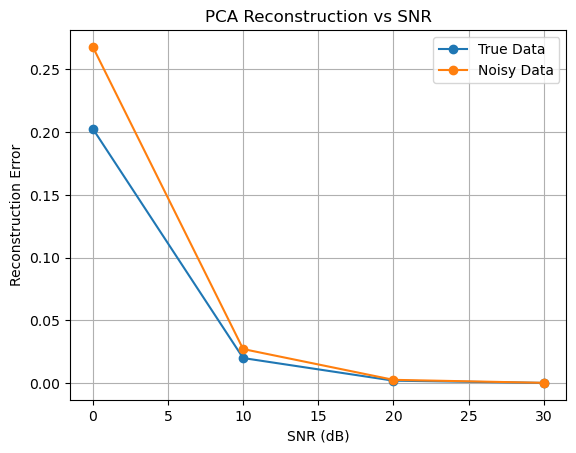

In [17]:
results_PPCA = []
for SNR_dB in SNR_dB_list:
    Ps = norm(X, 'fro')**2 / (N*M)
    Pn = Ps / (10**(SNR_dB / 10))
    sigma = np.sqrt(Pn)
    B = sigma * np.random.randn(N, M)
    X_noisy = X + B

    F_pca, U_pca, mu, sigma2, J = PPCA(X_noisy, K=K, nbIt=50)
    X_bar = F_pca @ U_pca.T
    
    reco_error_true = reconstruct_error(X, X_bar)
    reco_error_noisy = reconstruct_error(X_noisy, X_bar)
    angle_U = compute_angle(U, U_pca)
    angle_F = compute_angle(F, F_pca)
    results_PPCA.append((SNR_dB, reco_error_true, reco_error_noisy, angle_U, angle_F, J))

for r in results_PPCA:
    print(f"SNR={r[0]} dB | Reconstruction Error True={r[1]:.4f} | Reconstruction Error Noisy={r[2]:.4f} | Angle U and U_hat:{r[3]:.4f} rad | Angle F and F_hat:{r[4]:.4f}")

snr_vals, errors_true_PPCA, errors_noisy_PPCA, _, _, J_PPCA = zip(*results_PPCA)
plt.plot(snr_vals, errors_true_PPCA, marker='o', label="True Data")
plt.plot(snr_vals, errors_noisy_PPCA, marker='o', label="Noisy Data")
plt.xlabel("SNR (dB)")
plt.ylabel("Reconstruction Error")
plt.title("PCA Reconstruction vs SNR")
plt.legend()
plt.grid(True)
plt.show()

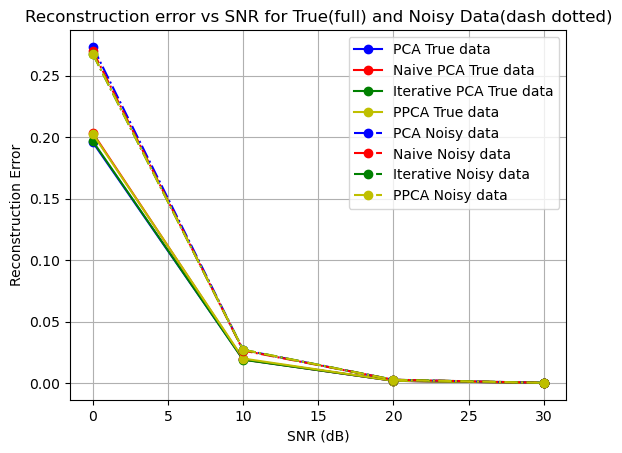

In [39]:
plt.plot(snr_vals, errors_true_PCA, "b", marker='o', label='PCA True data')
plt.plot(snr_vals, errors_true_NPCA,  "r", marker='o', label='Naive PCA True data')
plt.plot(snr_vals, errors_true_IPCA, "g", marker='o', label='Iterative PCA True data')
plt.plot(snr_vals, errors_true_PPCA, "y", marker='o', label='PPCA True data')
plt.plot(snr_vals, errors_noisy_PCA, "b", linestyle="dashdot" ,marker='o', label='PCA Noisy data')
plt.plot(snr_vals, errors_noisy_NPCA, "r", linestyle="dashdot", marker='o', label='Naive Noisy data')
plt.plot(snr_vals, errors_noisy_IPCA, "g", linestyle="dashdot", marker='o', label='Iterative Noisy data')
plt.plot(snr_vals, errors_noisy_PPCA, "y", linestyle="dashdot", marker='o', label='PPCA Noisy data')
plt.xlabel("SNR (dB)")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction error vs SNR for True(full) and Noisy Data(dash dotted)")
plt.legend()
plt.grid(True)
plt.show()

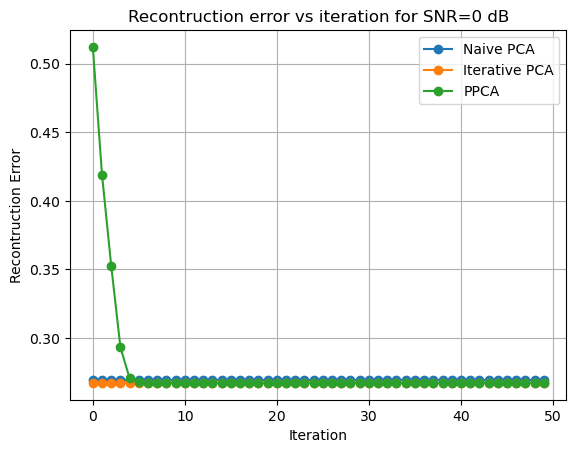

In [42]:
plt.plot(J_NPCA[0], marker='o', label='Naive PCA')
plt.plot(J_IPCA[0], marker='o', label='Iterative PCA')
plt.plot(J_PPCA[0], marker='o', label='PPCA')
plt.ylabel('Recontruction Error')
plt.xlabel('Iteration')
plt.title("Recontruction error vs iteration for SNR=0 dB")
plt.legend()
plt.grid(True)
plt.show()

## Noisy + Missing Data PCA

In [48]:
SNR_dB = 10
Ps = norm(X, 'fro')**2 / (N*M)
Pn = Ps / (10**(SNR_dB / 10))
sigma = np.sqrt(Pn)
B = sigma * np.random.randn(N, M)
X_noisy = X + B

missing_ratio_list = [0.1, 0.2, 0.3]  

Iteration 0: J = 0.024940, max|F| = 0.680, max|U| = 4.483
Iteration 10: J = 0.024904, max|F| = 0.679, max|U| = 4.474
Iteration 20: J = 0.024904, max|F| = 0.679, max|U| = 4.474
Iteration 30: J = 0.024904, max|F| = 0.679, max|U| = 4.474
Iteration 40: J = 0.024904, max|F| = 0.679, max|U| = 4.474
Iteration 0: J = 0.022471, max|F| = 1.220, max|U| = 3.462
Iteration 10: J = 0.022308, max|F| = 0.989, max|U| = 3.443
Iteration 20: J = 0.022308, max|F| = 0.989, max|U| = 3.443
Iteration 30: J = 0.022308, max|F| = 0.989, max|U| = 3.443
Iteration 40: J = 0.022308, max|F| = 0.989, max|U| = 3.443
Iteration 0: J = 0.018925, max|F| = 2.839, max|U| = 4.383
Iteration 10: J = 0.018343, max|F| = 5.080, max|U| = 4.280
Iteration 20: J = 0.018343, max|F| = 5.663, max|U| = 4.280
Iteration 30: J = 0.018343, max|F| = 5.698, max|U| = 4.280
Iteration 40: J = 0.018343, max|F| = 5.701, max|U| = 4.280
SNR=0.1 dB | Reconstruction Error True=0.0252 | Reconstruction Error Noisy=0.0330 | Angle U and U_hat:0.0265 rad | Ang

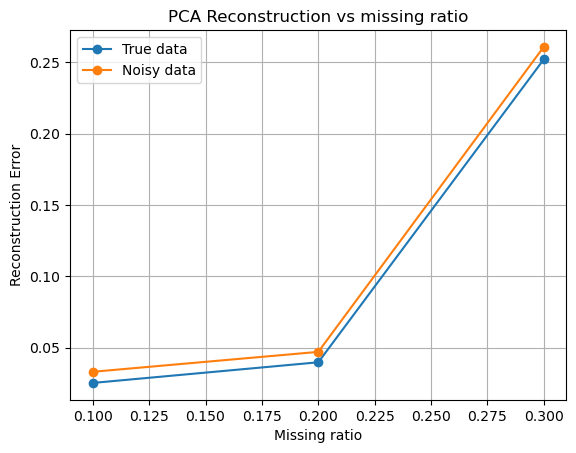

In [59]:
results_NPCA = []
for missing_ratio in missing_ratio_list:
    
    mask = np.random.rand(N, M) < missing_ratio
    X_missing = X_noisy.copy()
    X_missing[mask] = np.nan

    F_pca, U_pca, mu, J = naive_PCA(X_missing, n_components=K, nb_it=50)
    X_bar = F_pca @ U_pca.T
    
    reco_error_true = reconstruct_error(X, X_bar)
    reco_error_noisy = reconstruct_error(X_noisy, X_bar)
    angle_U = compute_angle(U, U_pca)
    angle_F = compute_angle(F, F_pca)
    results_NPCA.append((missing_ratio, reco_error_true, reco_error_noisy, angle_U, angle_F, J))

for r in results_NPCA:
    print(f"Missing ratio={r[0]} dB | Reconstruction Error True={r[1]:.4f} | Reconstruction Error Noisy={r[2]:.4f} | Angle U and U_hat:{r[3]:.4f} rad | Angle F and F_hat:{r[4]:.4f}")

missing_ratios, errors_true_NPCA, errors_noisy_NPCA, _, _, J_NPCA = zip(*results_NPCA)
plt.plot(missing_ratios, errors_true_NPCA, marker='o', label="True data")
plt.plot(missing_ratios, errors_noisy_NPCA, marker='o', label="Noisy data")
plt.xlabel("Missing ratio")
plt.ylabel("Reconstruction Error")
plt.title("PCA Reconstruction vs missing ratio")
plt.legend()
plt.grid(True)
plt.show()

Iteration 0: J = 0.037637
Iteration 10: J = 0.024788
Iteration 20: J = 0.024693
Iteration 30: J = 0.024681
Iteration 40: J = 0.024678
Iteration 0: J = 0.046673
Iteration 10: J = 0.022217
Iteration 20: J = 0.021842
Iteration 30: J = 0.021768
Iteration 40: J = 0.021745
Iteration 0: J = 0.060145
Iteration 10: J = 0.019754
Iteration 20: J = 0.018926
Iteration 30: J = 0.018697
Iteration 40: J = 0.018593
SNR=0.1 dB | Reconstruction Error True=0.0264 | Reconstruction Error Noisy=0.0338 | Angle U and U_hat:0.0251 rad | Angle F and F_hat:0.2774
SNR=0.2 dB | Reconstruction Error True=0.0344 | Reconstruction Error Noisy=0.0421 | Angle U and U_hat:0.0294 rad | Angle F and F_hat:0.3161
SNR=0.3 dB | Reconstruction Error True=0.0581 | Reconstruction Error Noisy=0.0652 | Angle U and U_hat:0.0375 rad | Angle F and F_hat:0.4060


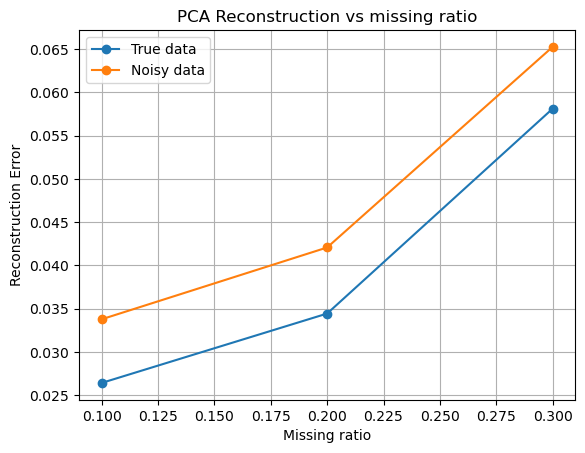

In [61]:
results_IPCA = []
for missing_ratio in missing_ratio_list:
    
    mask = np.random.rand(N, M) < missing_ratio
    X_missing = X_noisy.copy()
    X_missing[mask] = np.nan

    F_pca, U_pca, mu, J = IPCA(X_missing, n_components=K, nb_it=50)
    X_bar = F_pca @ U_pca.T
    
    reco_error_true = reconstruct_error(X, X_bar)
    reco_error_noisy = reconstruct_error(X_noisy, X_bar)
    angle_U = compute_angle(U, U_pca)
    angle_F = compute_angle(F, F_pca)
    results_IPCA.append((missing_ratio, reco_error_true, reco_error_noisy, angle_U, angle_F, J))

for r in results_IPCA:
    print(f"Missing ratio={r[0]} dB | Reconstruction Error True={r[1]:.4f} | Reconstruction Error Noisy={r[2]:.4f} | Angle U and U_hat:{r[3]:.4f} rad | Angle F and F_hat:{r[4]:.4f}")

missing_ratios, errors_true_IPCA, errors_noisy_IPCA, _, _, J_IPCA = zip(*results_IPCA)
plt.plot(missing_ratios, errors_true_IPCA, marker='o', label="True data")
plt.plot(missing_ratios, errors_noisy_IPCA, marker='o', label="Noisy data")
plt.xlabel("Missing ratio")
plt.ylabel("Reconstruction Error")
plt.title("PCA Reconstruction vs missing ratio")
plt.legend()
plt.grid(True)
plt.show()

Iteration 10: J = 0.024340, sigma2 = 0.000001
Iteration 20: J = 0.024340, sigma2 = 0.000001
Iteration 30: J = 0.024340, sigma2 = 0.000001
Iteration 40: J = 0.024340, sigma2 = 0.000001
Iteration 50: J = 0.024340, sigma2 = 0.000001
Iteration 60: J = 0.024340, sigma2 = 0.000001
Iteration 70: J = 0.024340, sigma2 = 0.000001
Iteration 80: J = 0.024340, sigma2 = 0.000001
Iteration 90: J = 0.024340, sigma2 = 0.000001
Iteration 100: J = 0.024340, sigma2 = 0.000001
Iteration 110: J = 0.024340, sigma2 = 0.000001
Iteration 120: J = 0.024340, sigma2 = 0.000001
Iteration 130: J = 0.024340, sigma2 = 0.000001
Iteration 140: J = 0.024340, sigma2 = 0.000001
Iteration 150: J = 0.024340, sigma2 = 0.000001
Iteration 160: J = 0.024340, sigma2 = 0.000001
Iteration 170: J = 0.024340, sigma2 = 0.000001
Iteration 180: J = 0.024340, sigma2 = 0.000001
Iteration 190: J = 0.024340, sigma2 = 0.000001
Iteration 200: J = 0.024340, sigma2 = 0.000001
Iteration 210: J = 0.024340, sigma2 = 0.000001
Iteration 220: J = 0.0

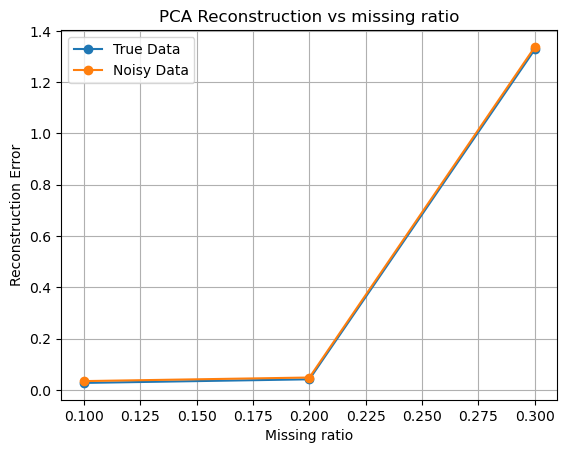

In [62]:
results_PPCA = []
for missing_ratio in missing_ratio_list:
    
    mask = np.random.rand(N, M) < missing_ratio
    X_missing = X_noisy.copy()
    X_missing[mask] = np.nan

    F_pca, U_pca, mu, sigma2, J = PPCA(X_missing, K=K, nbIt=300)
    X_bar = F_pca @ U_pca.T
    
    reco_error_true = reconstruct_error(X, X_bar)
    reco_error_noisy = reconstruct_error(X_noisy, X_bar)
    angle_U = compute_angle(U, U_pca)
    angle_F = compute_angle(F, F_pca)
    results_PPCA.append((missing_ratio, reco_error_true, reco_error_noisy, angle_U, angle_F, J))

for r in results_PPCA:
    print(f"Missing ratio={r[0]} dB | Reconstruction Error True={r[1]:.4f} | Reconstruction Error Noisy={r[2]:.4f} | Angle U and U_hat:{r[3]:.4f} rad | Angle F and F_hat:{r[4]:.4f}")

missing_ratios, errors_true_PPCA, errors_noisy_PPCA, _, _, J_PPCA = zip(*results_PPCA)
plt.plot(missing_ratios, errors_true_PPCA, marker='o', label="True Data")
plt.plot(missing_ratios, errors_noisy_PPCA, marker='o', label="Noisy Data")
plt.xlabel("Missing ratio")
plt.ylabel("Reconstruction Error")
plt.title("PCA Reconstruction vs missing ratio")
plt.legend()
plt.grid(True)
plt.show()

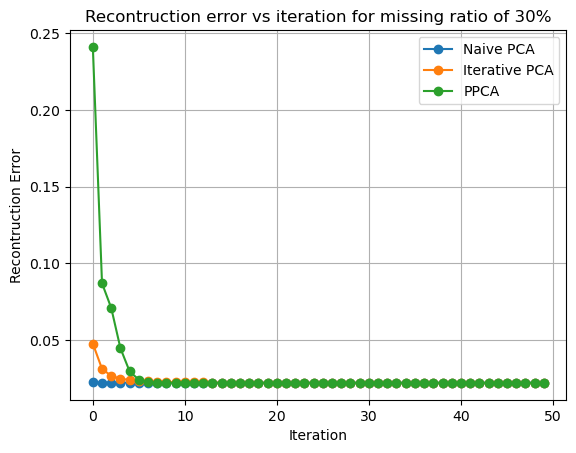

In [58]:
plt.plot(J_NPCA[1], marker='o', label='Naive PCA')
plt.plot(J_IPCA[1], marker='o', label='Iterative PCA')
plt.plot(J_PPCA[1], marker='o', label='PPCA')
plt.ylabel('Recontruction Error')
plt.xlabel('Iteration')
plt.title("Recontruction error vs iteration for missing ratio of 30%")
plt.legend()
plt.grid(True)
plt.show()

## Real Decathlon values

In [69]:
missing_data_path = "Programs_Students/DataDecathlon.mat"
missing_data = loadmat(missing_data_path)

full_data_path = "Programs_Students/DataDecathlon_Complete.mat"
full_data = loadmat(full_data_path)

name_variables = ["100m", "Longueur", "Poids", "Hauteur", "400m", "110m", "Disque", "Perche", "Javelot", "1500"]

Evaluating Naive PCA
Iteration 0: J = 578.344768, max|F| = 14.436, max|U| = 17.679
Iteration 10: J = 554.496701, max|F| = 13.164, max|U| = 17.416
Iteration 20: J = 554.197714, max|F| = 13.042, max|U| = 17.606
Iteration 30: J = 554.171572, max|F| = 12.998, max|U| = 17.690
Iteration 40: J = 554.168071, max|F| = 12.984, max|U| = 17.722
Reconstruction error: 1934.116436431073


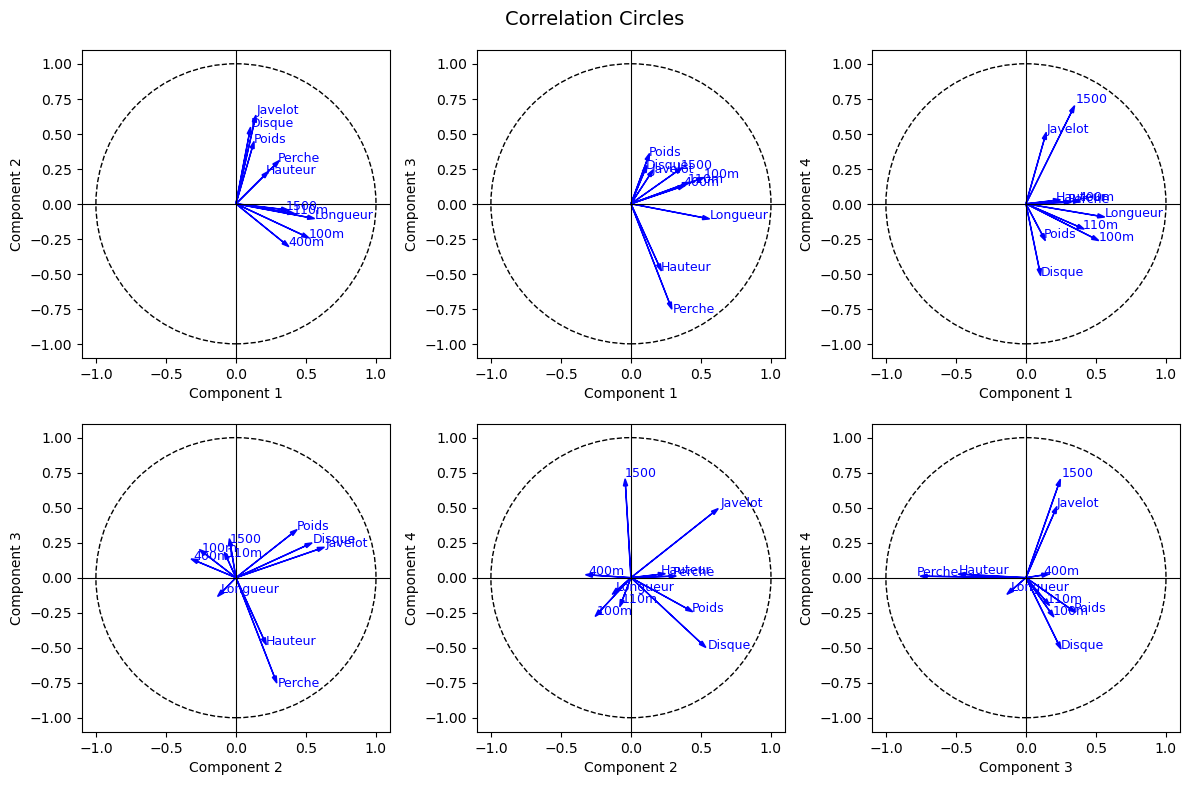

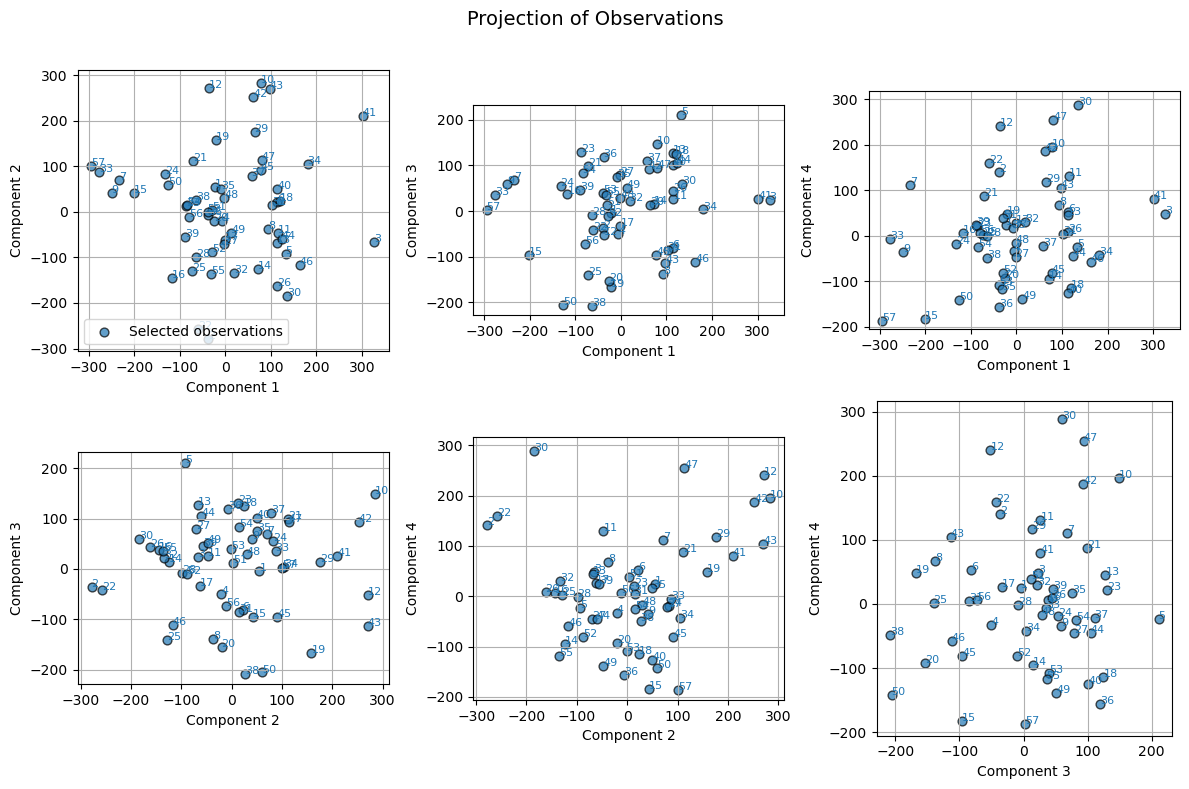

In [70]:
print("Evaluating Naive PCA")
F_pca, U_pca, mu, J_NPCA = naive_PCA(missing_data["Data"], n_components=5, nb_it=50)

X_reconstruct = F_pca@U_pca.T + np.ones((full_data["Data"].shape[0], 1))@mu.reshape(1, -1)

print(f"Reconstruction error: {reconstruct_error(full_data["Data"], X_reconstruct)}")

correlation_circle = U_pca / np.linalg.norm(U_pca, axis=0)

index_selected_points = np.arange(1, F_pca.shape[0] + 1)

plot_correlation_circle(
correlation_circle=correlation_circle,
name_variables=name_variables,
nb_axes=4,
fig_number=1
)

plot_projection_observation(
    C=F_pca,
    index_selected_points=index_selected_points,
    nb_axes=4,
    fig_number=2
)

Iteration 0: J = 742.205821
Iteration 10: J = 566.752503
Iteration 20: J = 552.084535
Iteration 30: J = 548.896345
Iteration 40: J = 547.684107
Reconstruction error: 1776.624240927522


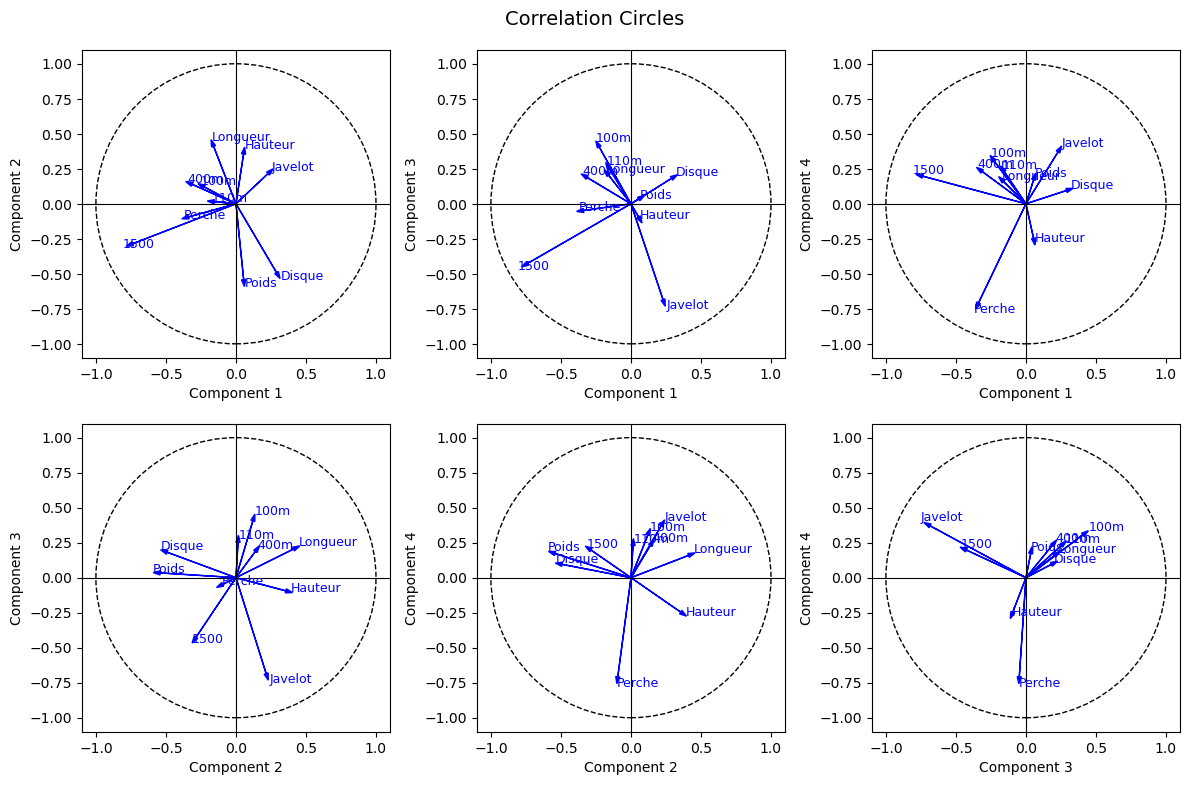

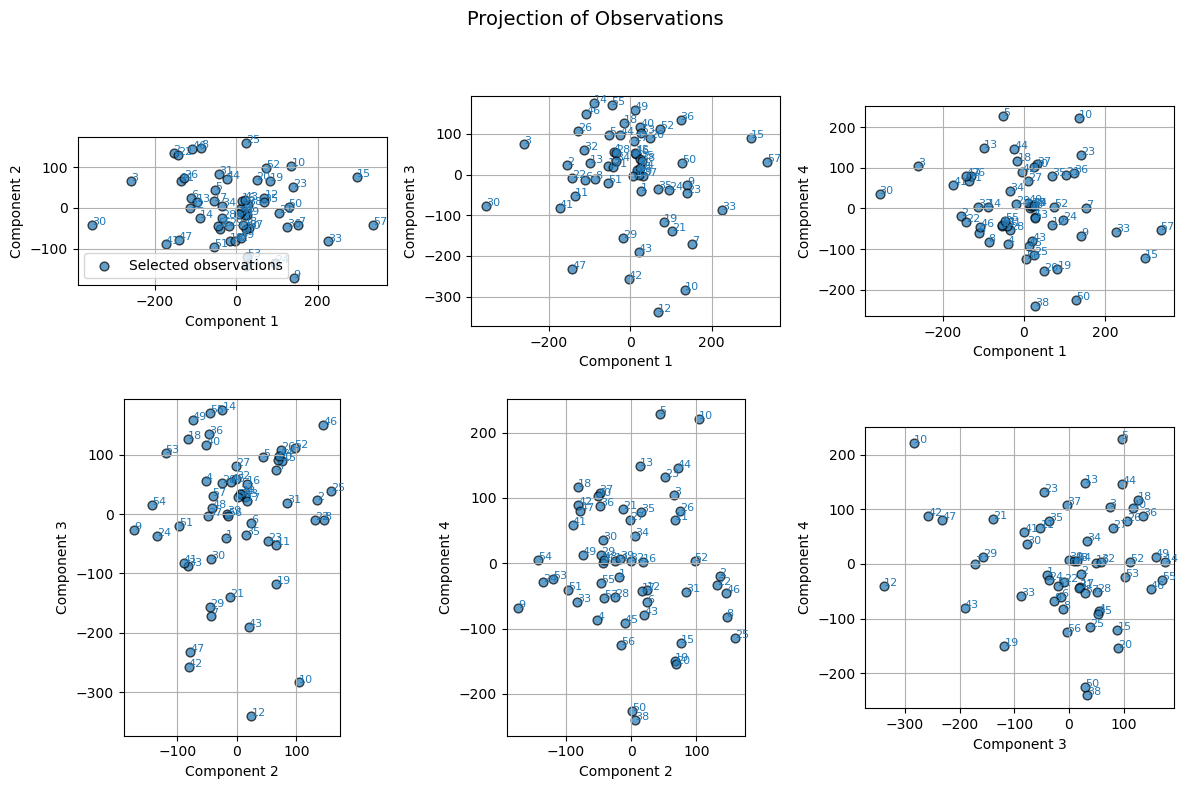

In [71]:
F_pca, U_pca, mu, J_IPCA = IPCA(missing_data["Data"], n_components=5, nb_it=50)

X_reconstruct = F_pca@U_pca.T + np.ones((full_data["Data"].shape[0], 1))@mu.reshape(1, -1)

print(f"Reconstruction error: {reconstruct_error(full_data["Data"], X_reconstruct)}")

correlation_circle = U_pca / np.linalg.norm(U_pca, axis=0)

index_selected_points = np.arange(1, F_pca.shape[0] + 1)

plot_correlation_circle(
correlation_circle=correlation_circle,
name_variables=name_variables,
nb_axes=4,
fig_number=1
)

plot_projection_observation(
    C=F_pca,
    index_selected_points=index_selected_points,
    nb_axes=4,
    fig_number=2
)

Iteration 10: J = 548.457470, sigma2 = 0.000001
Iteration 20: J = 546.534924, sigma2 = 0.000001
Iteration 30: J = 546.403746, sigma2 = 0.000001
Iteration 40: J = 546.383602, sigma2 = 0.000001
Iteration 50: J = 546.379544, sigma2 = 0.000001
Reconstruction error: 2042.378396667138


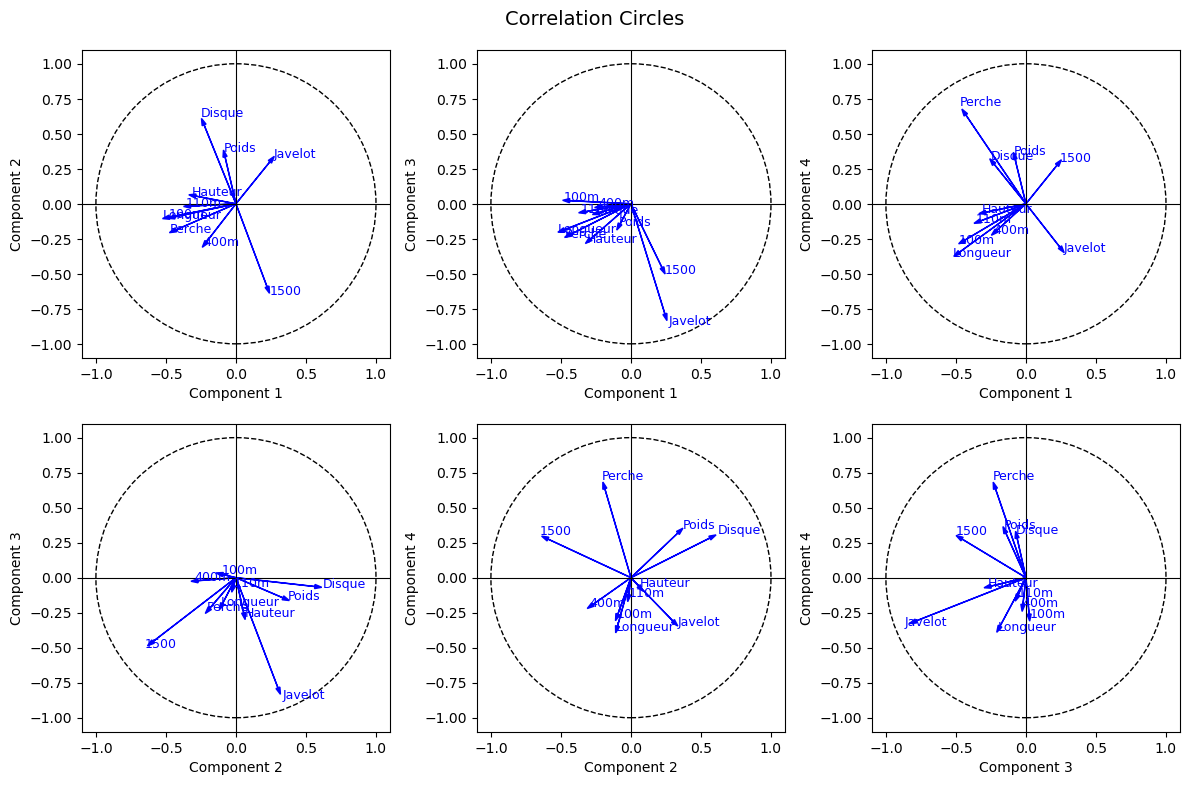

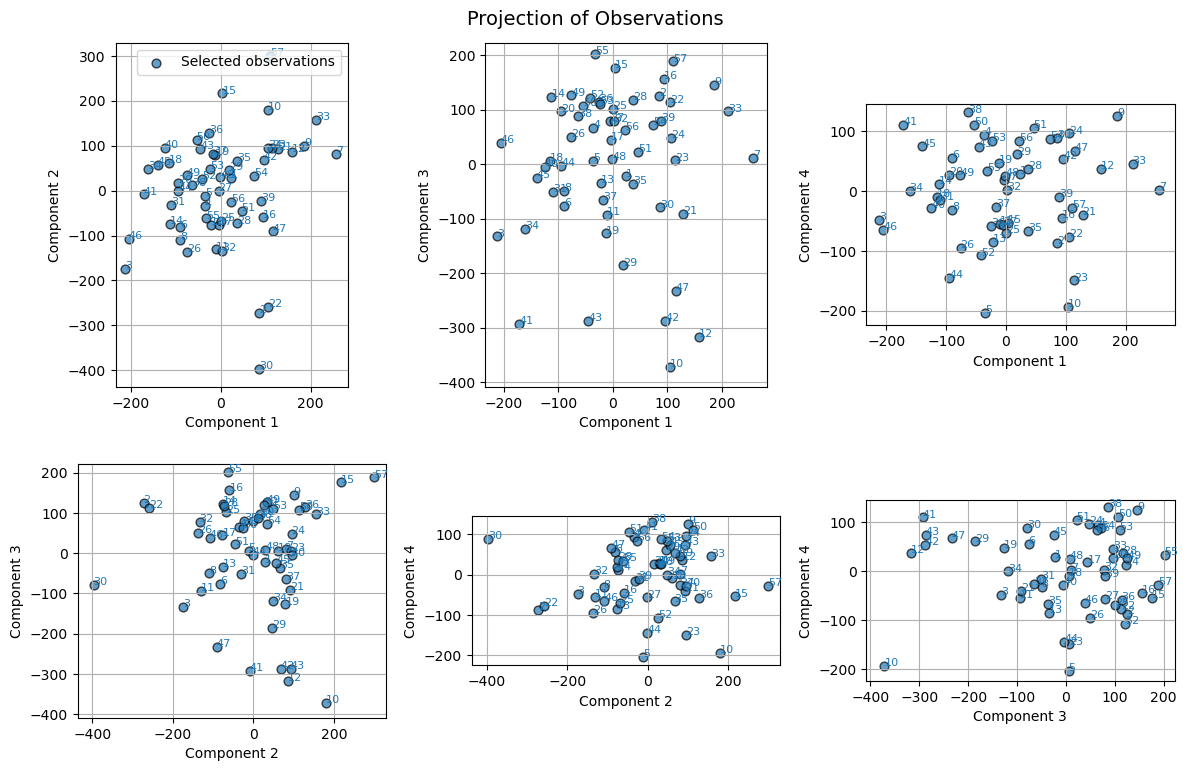

In [72]:
F_pca, U_pca, mu, sigma2, J_PPCA = PPCA(missing_data["Data"], K=5, nbIt=50)
X_reconstruct = F_pca@U_pca.T + np.ones((full_data["Data"].shape[0], 1))@mu.reshape(1, -1)

print(f"Reconstruction error: {reconstruct_error(full_data["Data"], X_reconstruct)}")

correlation_circle = U_pca / np.linalg.norm(U_pca, axis=0)

index_selected_points = np.arange(1, F_pca.shape[0] + 1)

plot_correlation_circle(
correlation_circle=correlation_circle,
name_variables=name_variables,
nb_axes=4,
fig_number=1
)

plot_projection_observation(
    C=F_pca,
    index_selected_points=index_selected_points,
    nb_axes=4,
    fig_number=2
)

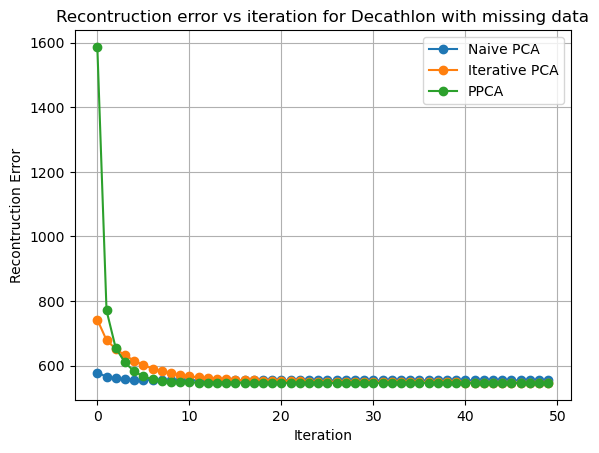

In [73]:
plt.plot(J_NPCA, marker='o', label='Naive PCA')
plt.plot(J_IPCA, marker='o', label='Iterative PCA')
plt.plot(J_PPCA, marker='o', label='PPCA')
plt.ylabel('Recontruction Error')
plt.xlabel('Iteration')
plt.title("Recontruction error vs iteration for Decathlon with missing data")
plt.legend()
plt.grid(True)
plt.show()